In [37]:
from dotenv import load_dotenv
import os
from datetime import datetime, timezone, timedelta
import seaborn as sns 
import matplotlib.dates as mdates
import matplotlib.pylab as plt 

from analysis.analysis_functions import get_data, plot_daily_bars, plot_hourly_avg, kwh_meters_rename_dict, electric_variables, electrical_groups_dict_inv

%load_ext autoreload 
%autoreload 2

load_dotenv()

API_TOKEN = os.getenv("ENERGY_REPORT_API_TOKEN")

sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
start = datetime.now(timezone.utc) - timedelta(days=14)
stop = datetime.now(timezone.utc)
window_size = timedelta(minutes=10)

In [39]:
# Report of the Power Hub performance over the last week

In [40]:
thermal_variables = [
    "heat_pipes_power",
    "cold_reservoir_cooling_demand",
    "cold_reservoir_cooling_supply",
    "yazaki_chill_power",
    "chiller_chill_power",
]

water_variables = [
    "water_maker_production_flow",
    "fresh_to_kitchen_flow_sensor_total_volume",
    "technical_to_wash_off_flow_sensor_total_volume",
    "technical_to_sanitary_flow_sensor_total_volume"
]

battery_levels = ["electrical_battery_system_soc", "pcm_state_of_charge"]



## Electric

In [42]:
electric_data = await get_data([{"_field": variable} for variable in electric_variables], (start, stop), timedelta(hours = 1), fl.WindowOperation.MEAN, API_TOKEN)
electric_data.index = electric_data.index.tz_convert('Europe/Madrid')

electric_data = electric_data.rename(columns = kwh_meters_rename_dict)
kwh_electric = (electric_data / 1000).resample('h').mean()

In [43]:
### Aggregate electric consumption and production

In [44]:
aggregate_electric = kwh_electric.fillna(0).T.groupby(electrical_groups_dict_inv).sum().T.rename(columns = {"AC_power":"consumption", "grid_power":"grid","pv_power":"PV production"})

In [46]:
consumed = aggregate_electric['grid'].to_frame().assign(renewable = aggregate_electric['consumption'] - aggregate_electric['grid'])

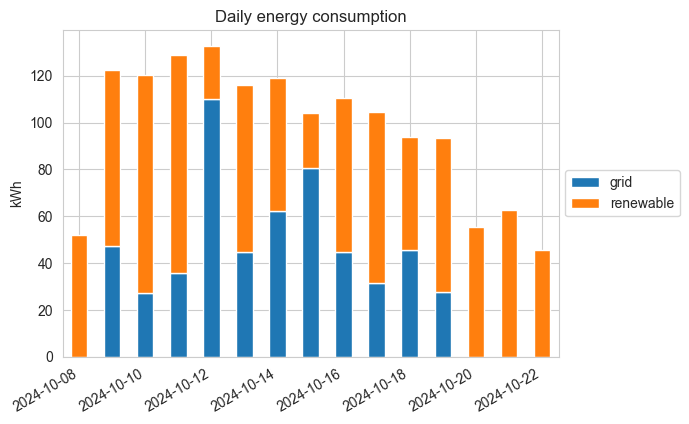

In [47]:
daily_consumed = consumed.resample('d').sum()
daily_consumed.index = daily_consumed.index.date
ax = daily_consumed.plot(kind="bar", stacked=True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gcf().autofmt_xdate()
ax.set_ylabel("kWh")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Daily energy consumption");

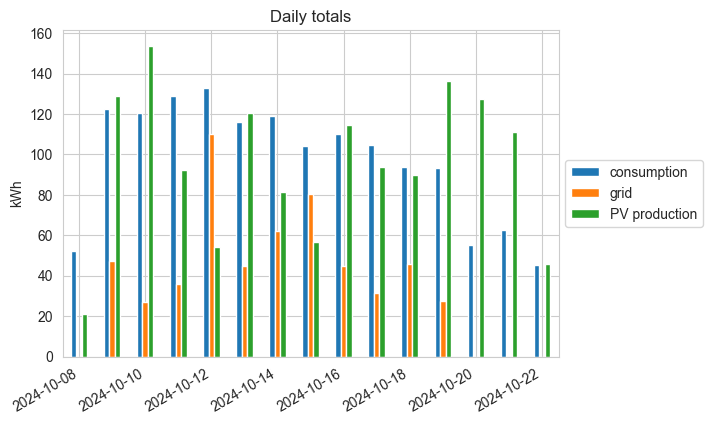

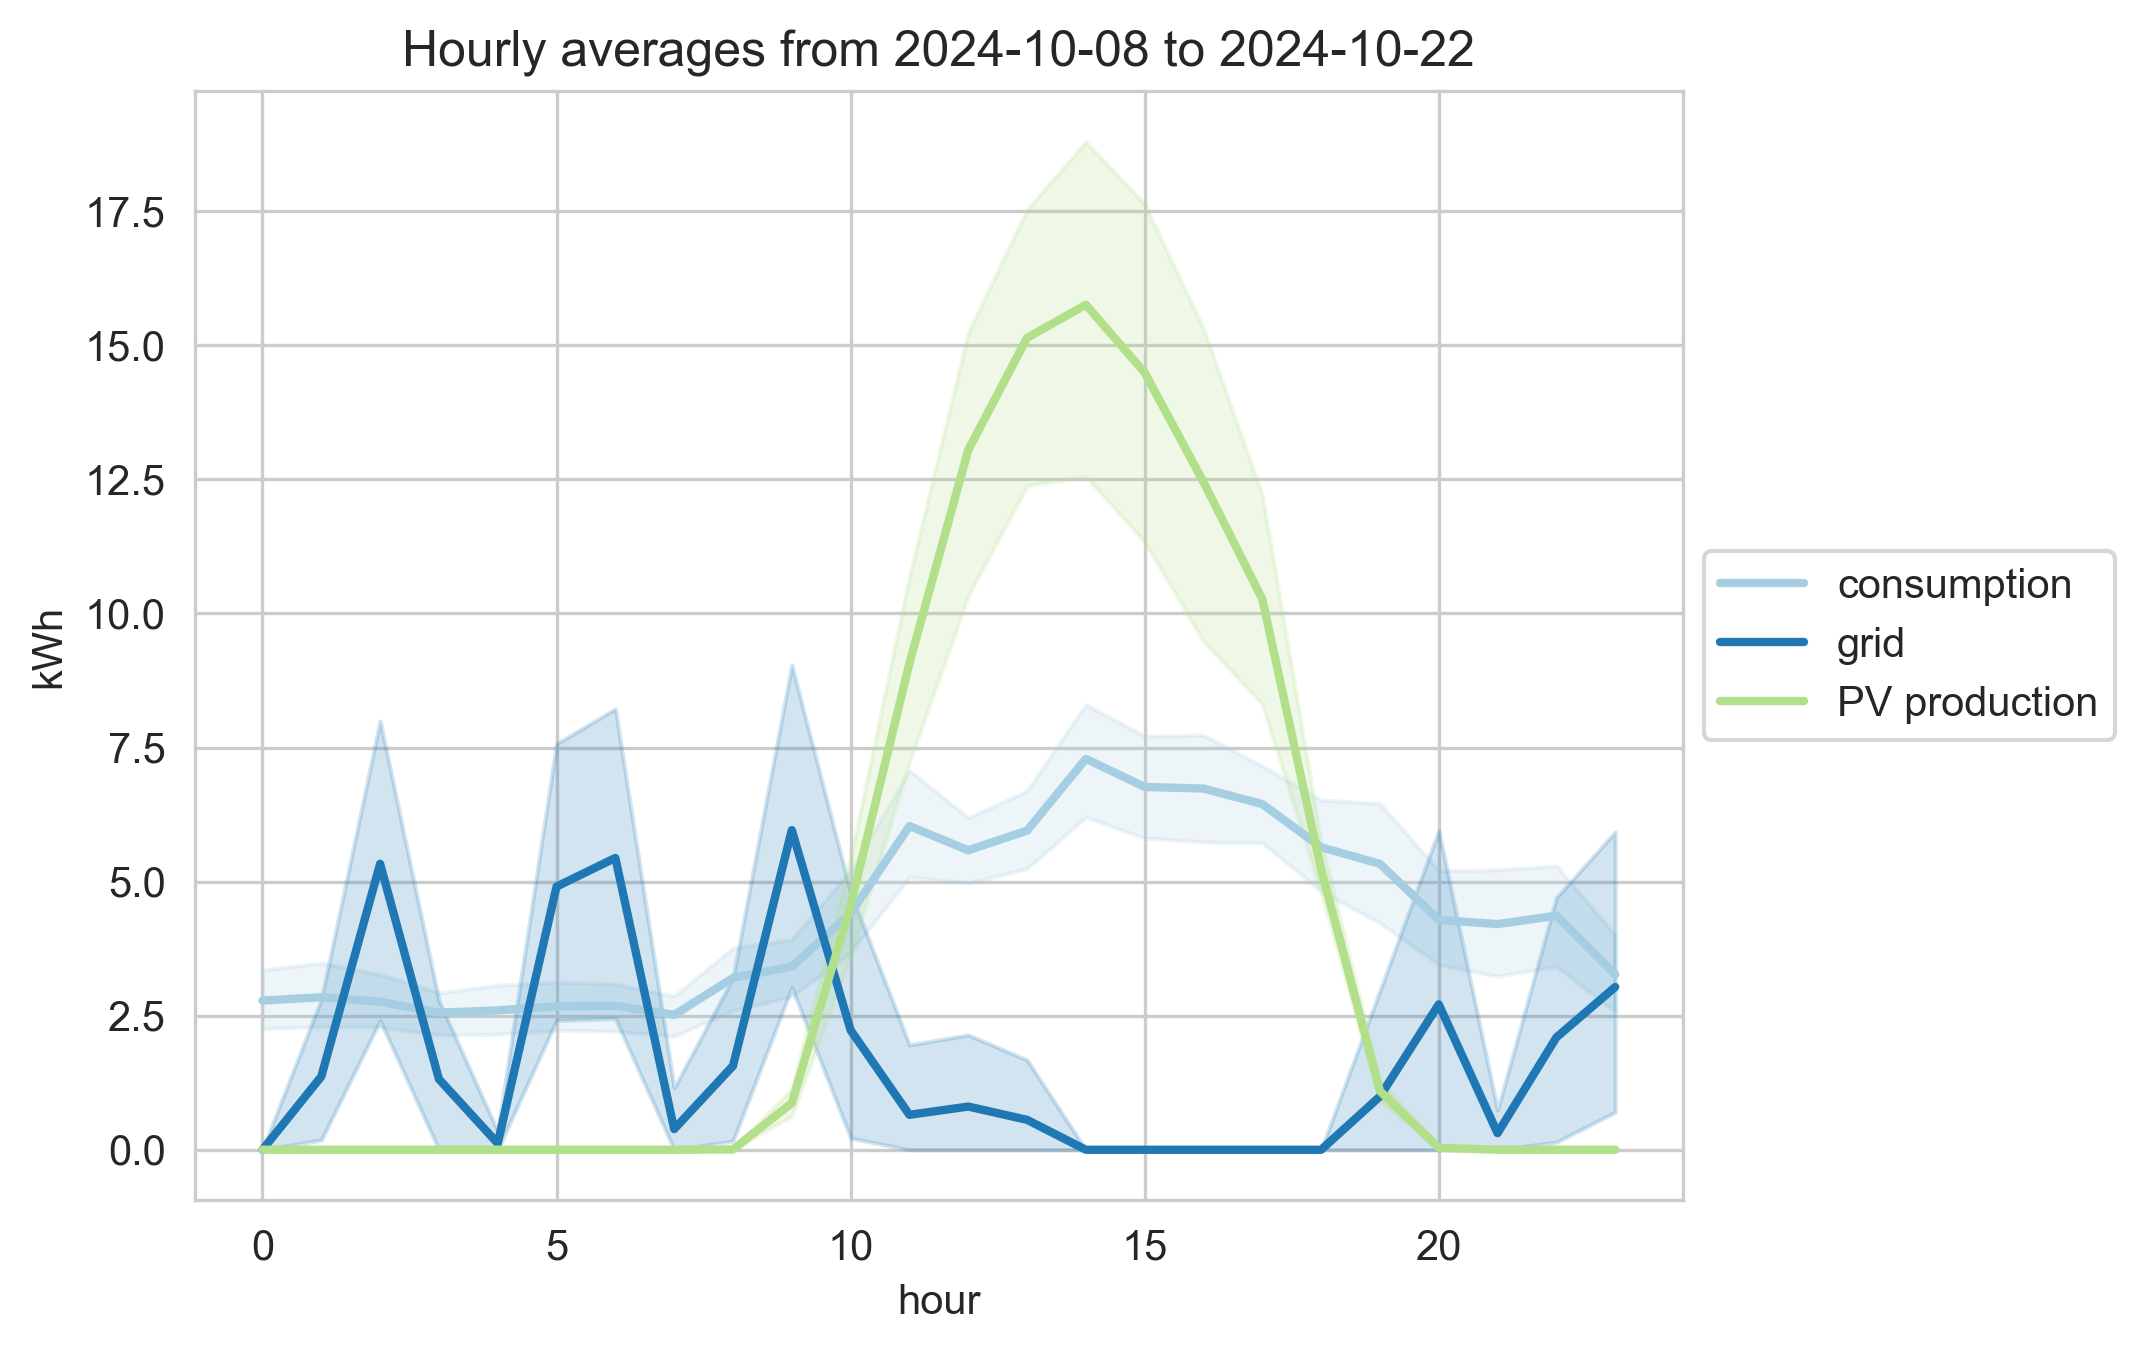

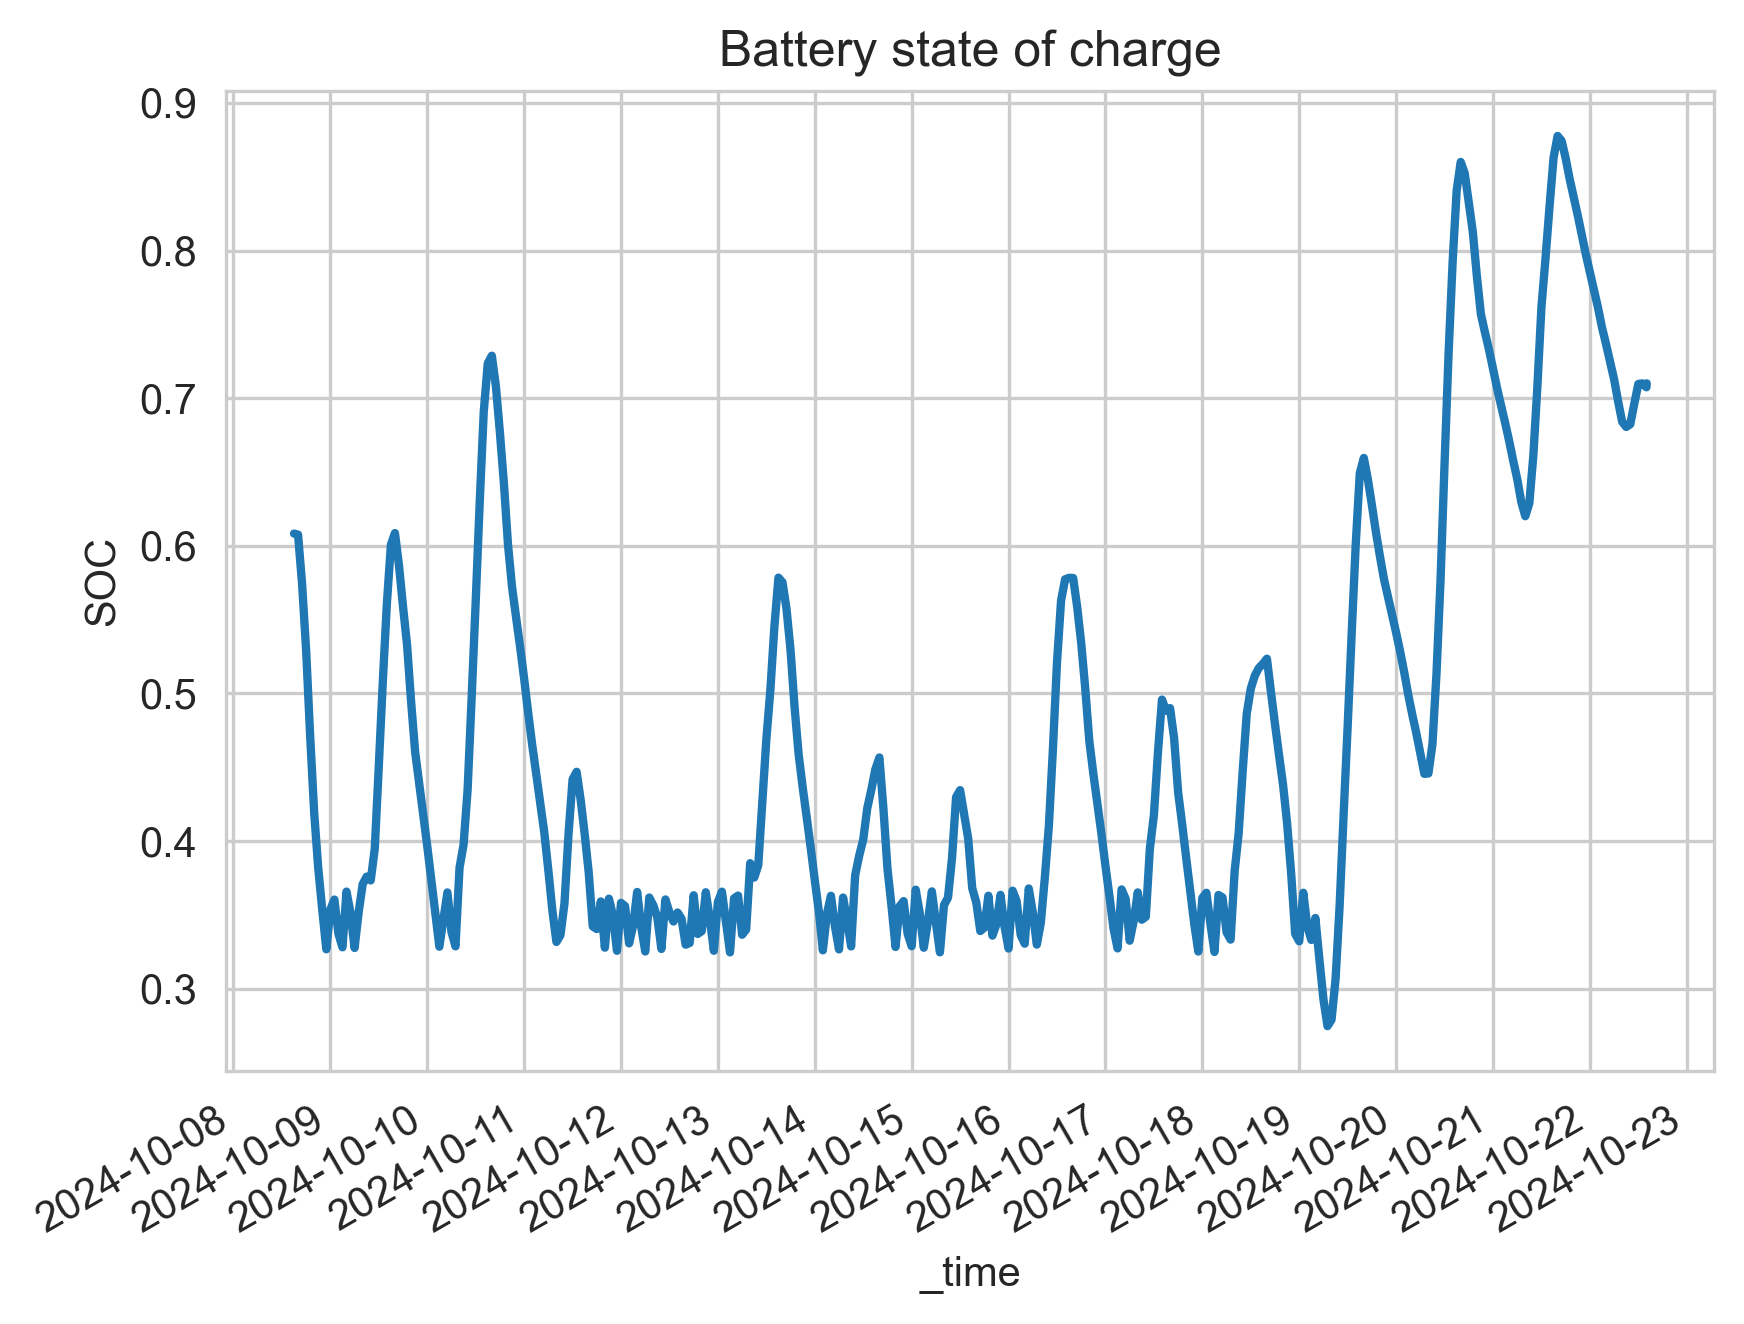

In [48]:
plot_daily_bars(aggregate_electric, 'kWh')
plot_hourly_avg(aggregate_electric, 'kWh')

fig, ax = plt.subplots(dpi = 300)
ax = sns.lineplot(data = electric_data['electrical_battery_system_soc'].rename('SOC', inplace = True), dashes = False, linewidth = 2.0, ax = ax)
ax.set_title('Battery state of charge')
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
plt.gcf().autofmt_xdate()


### Breakdown of electrical energy consumption

In [49]:
# consumer_groups = kwh_electric.T.groupby(electrical_consumption_groups_dict_inv).sum().T
# totals = consumer_groups.sum(1).to_frame('total_AC_consumers').assign(AC_power = aggregate_electric['AC_power'])
# totals.plot(ylabel = 'kW')


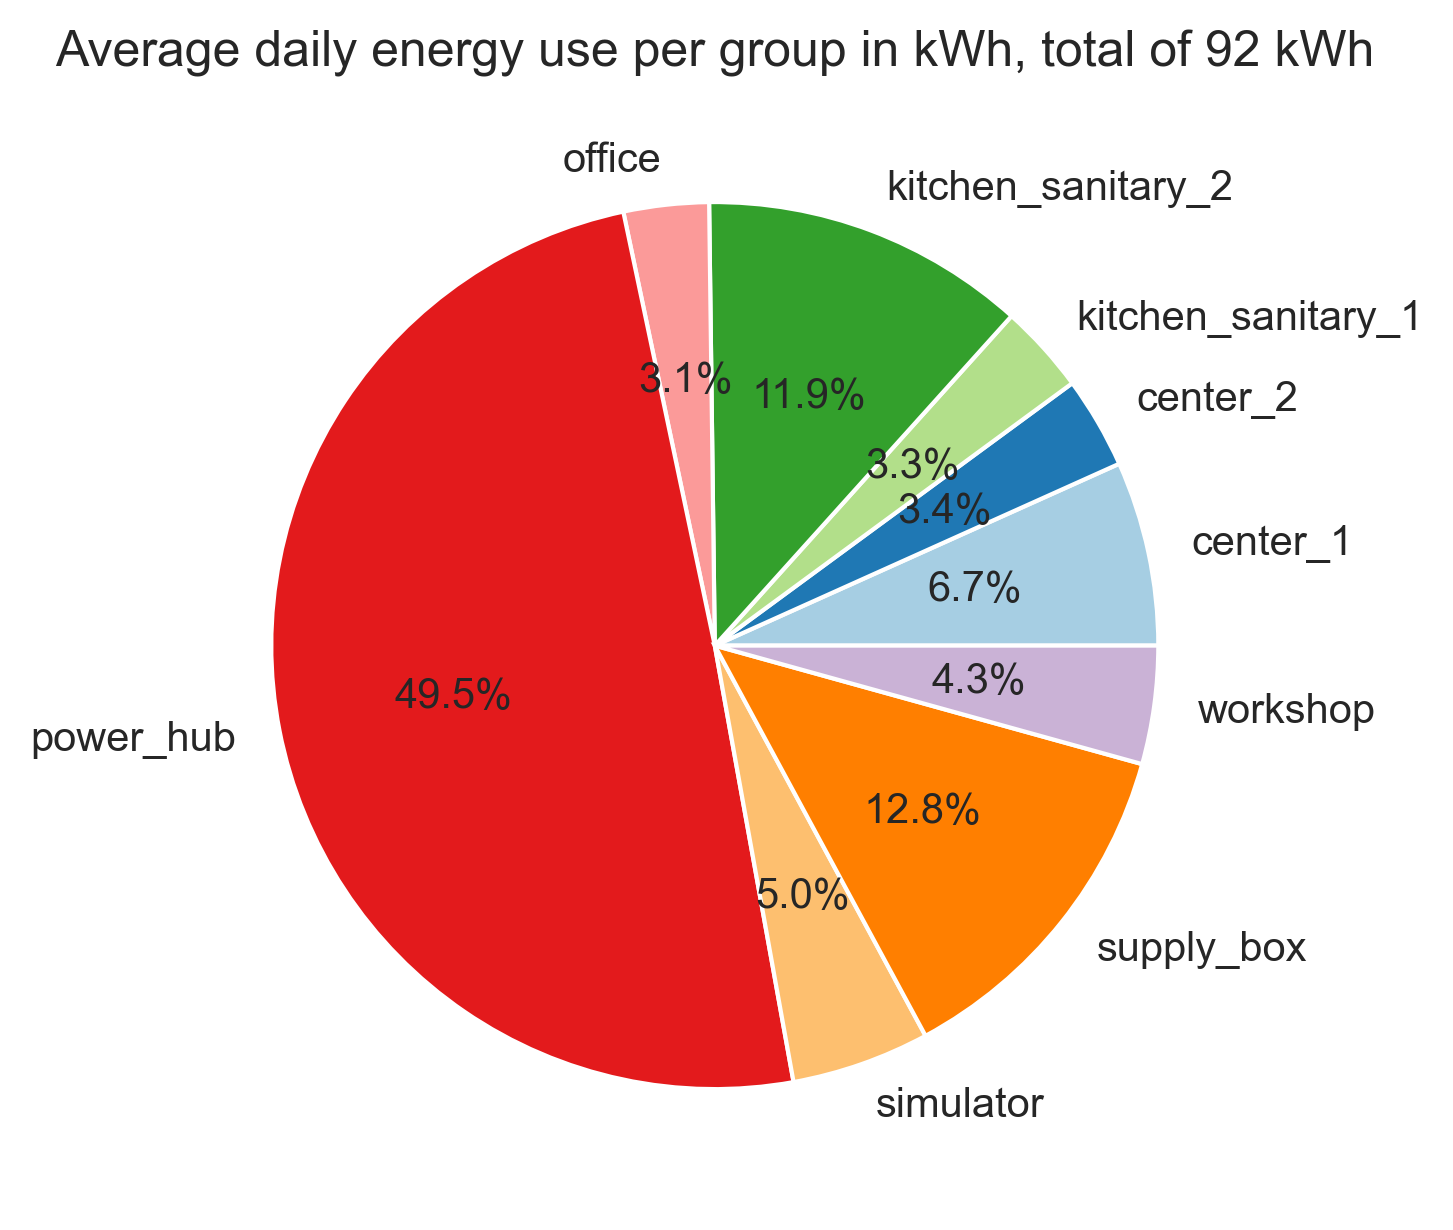

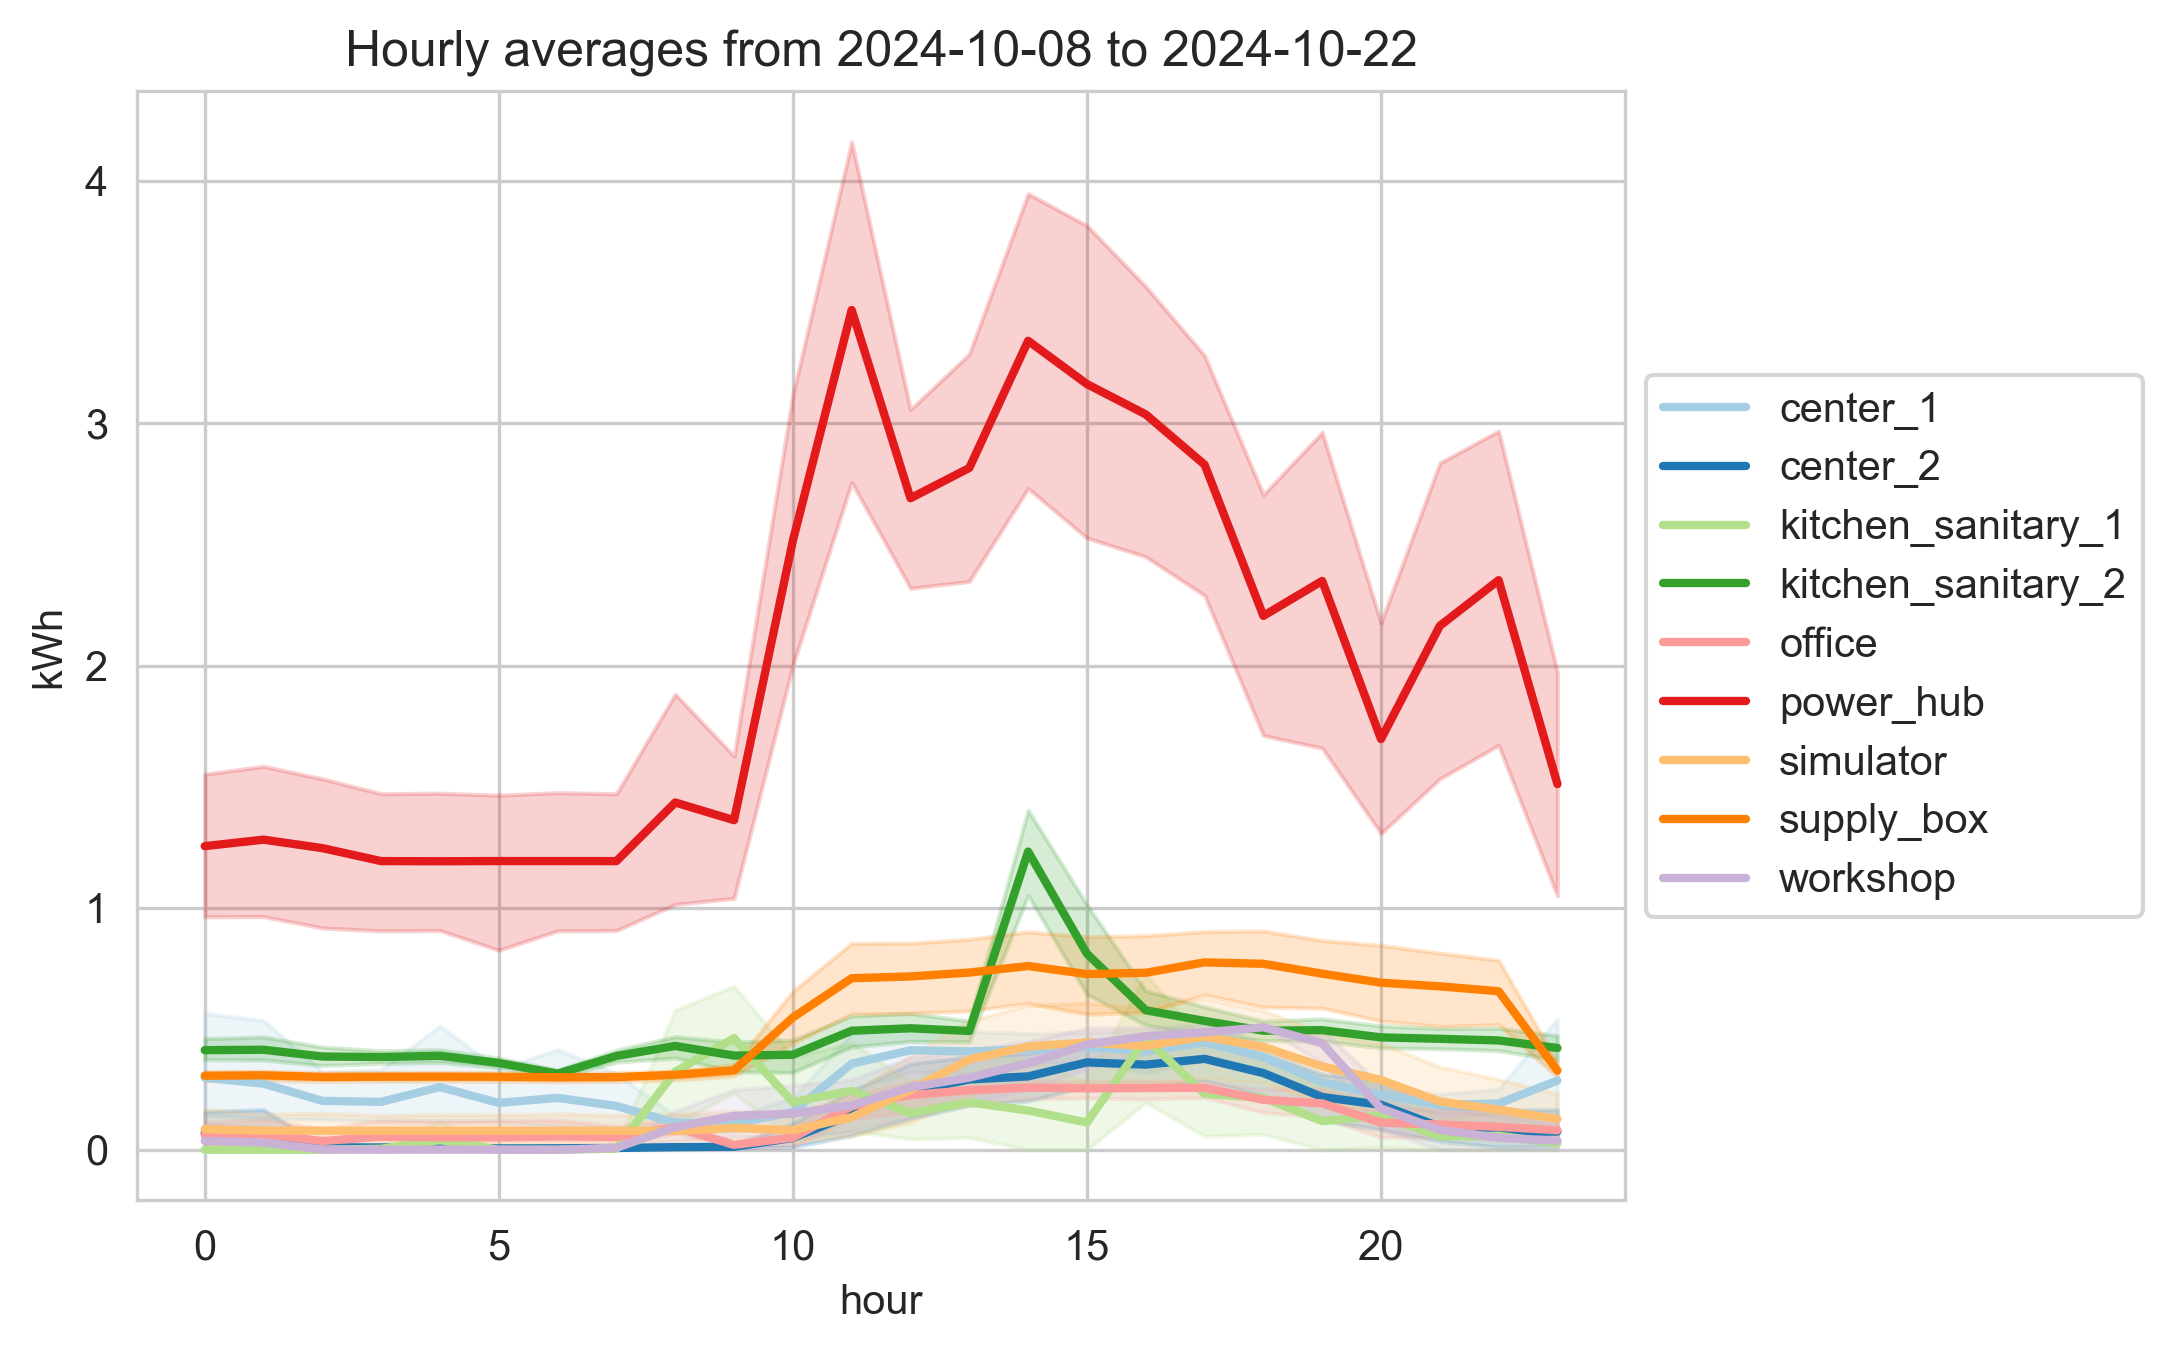

In [50]:
hourly_per_group = kwh_electric.T.groupby(electrical_consumption_groups_dict_inv).sum().T
daily_per_group = hourly_per_group.resample('d').sum()
daily_means = daily_per_group.mean()

fig, ax = plt.subplots(dpi = 300)
plt.pie(daily_means, labels =daily_means.index, autopct='%1.1f%%', colors = sns.color_palette("Paired"))
plt.title(f'Average daily energy use per group in kWh, total of {daily_per_group.mean().sum():.0f} kWh')

plot_hourly_avg(hourly_per_group, 'kWh');

## Thermal 

### Aggregate thermal consumption and production

In [52]:
thermal_variables = [
    #"heat_pipes_power",
    "cold_reservoir_cooling_demand",
    "yazaki_chill_power",
    "chiller_chill_power",
]

thermal_data = await get_data([{"_field": variable} for variable in thermal_variables], (start, stop), timedelta(minutes = 1), fl.WindowOperation.MEAN, API_TOKEN)
thermal_data.index = thermal_data.index.tz_convert('Europe/Madrid')
thermal_data = thermal_data.rename(columns = {"cold_reservoir_cooling_demand":"cold consumed",
    "yazaki_chill_power":"yazaki cold production",
    "chiller_chill_power":"chiller cold production"})

kwh_thermal = (thermal_data / 1000).fillna(0).resample('h').mean()

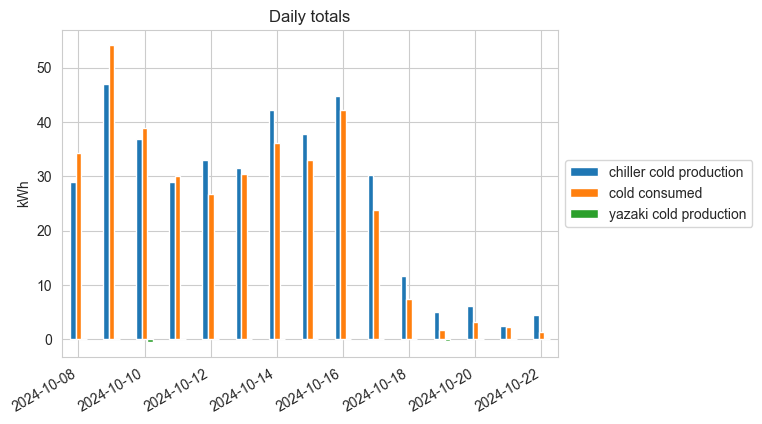

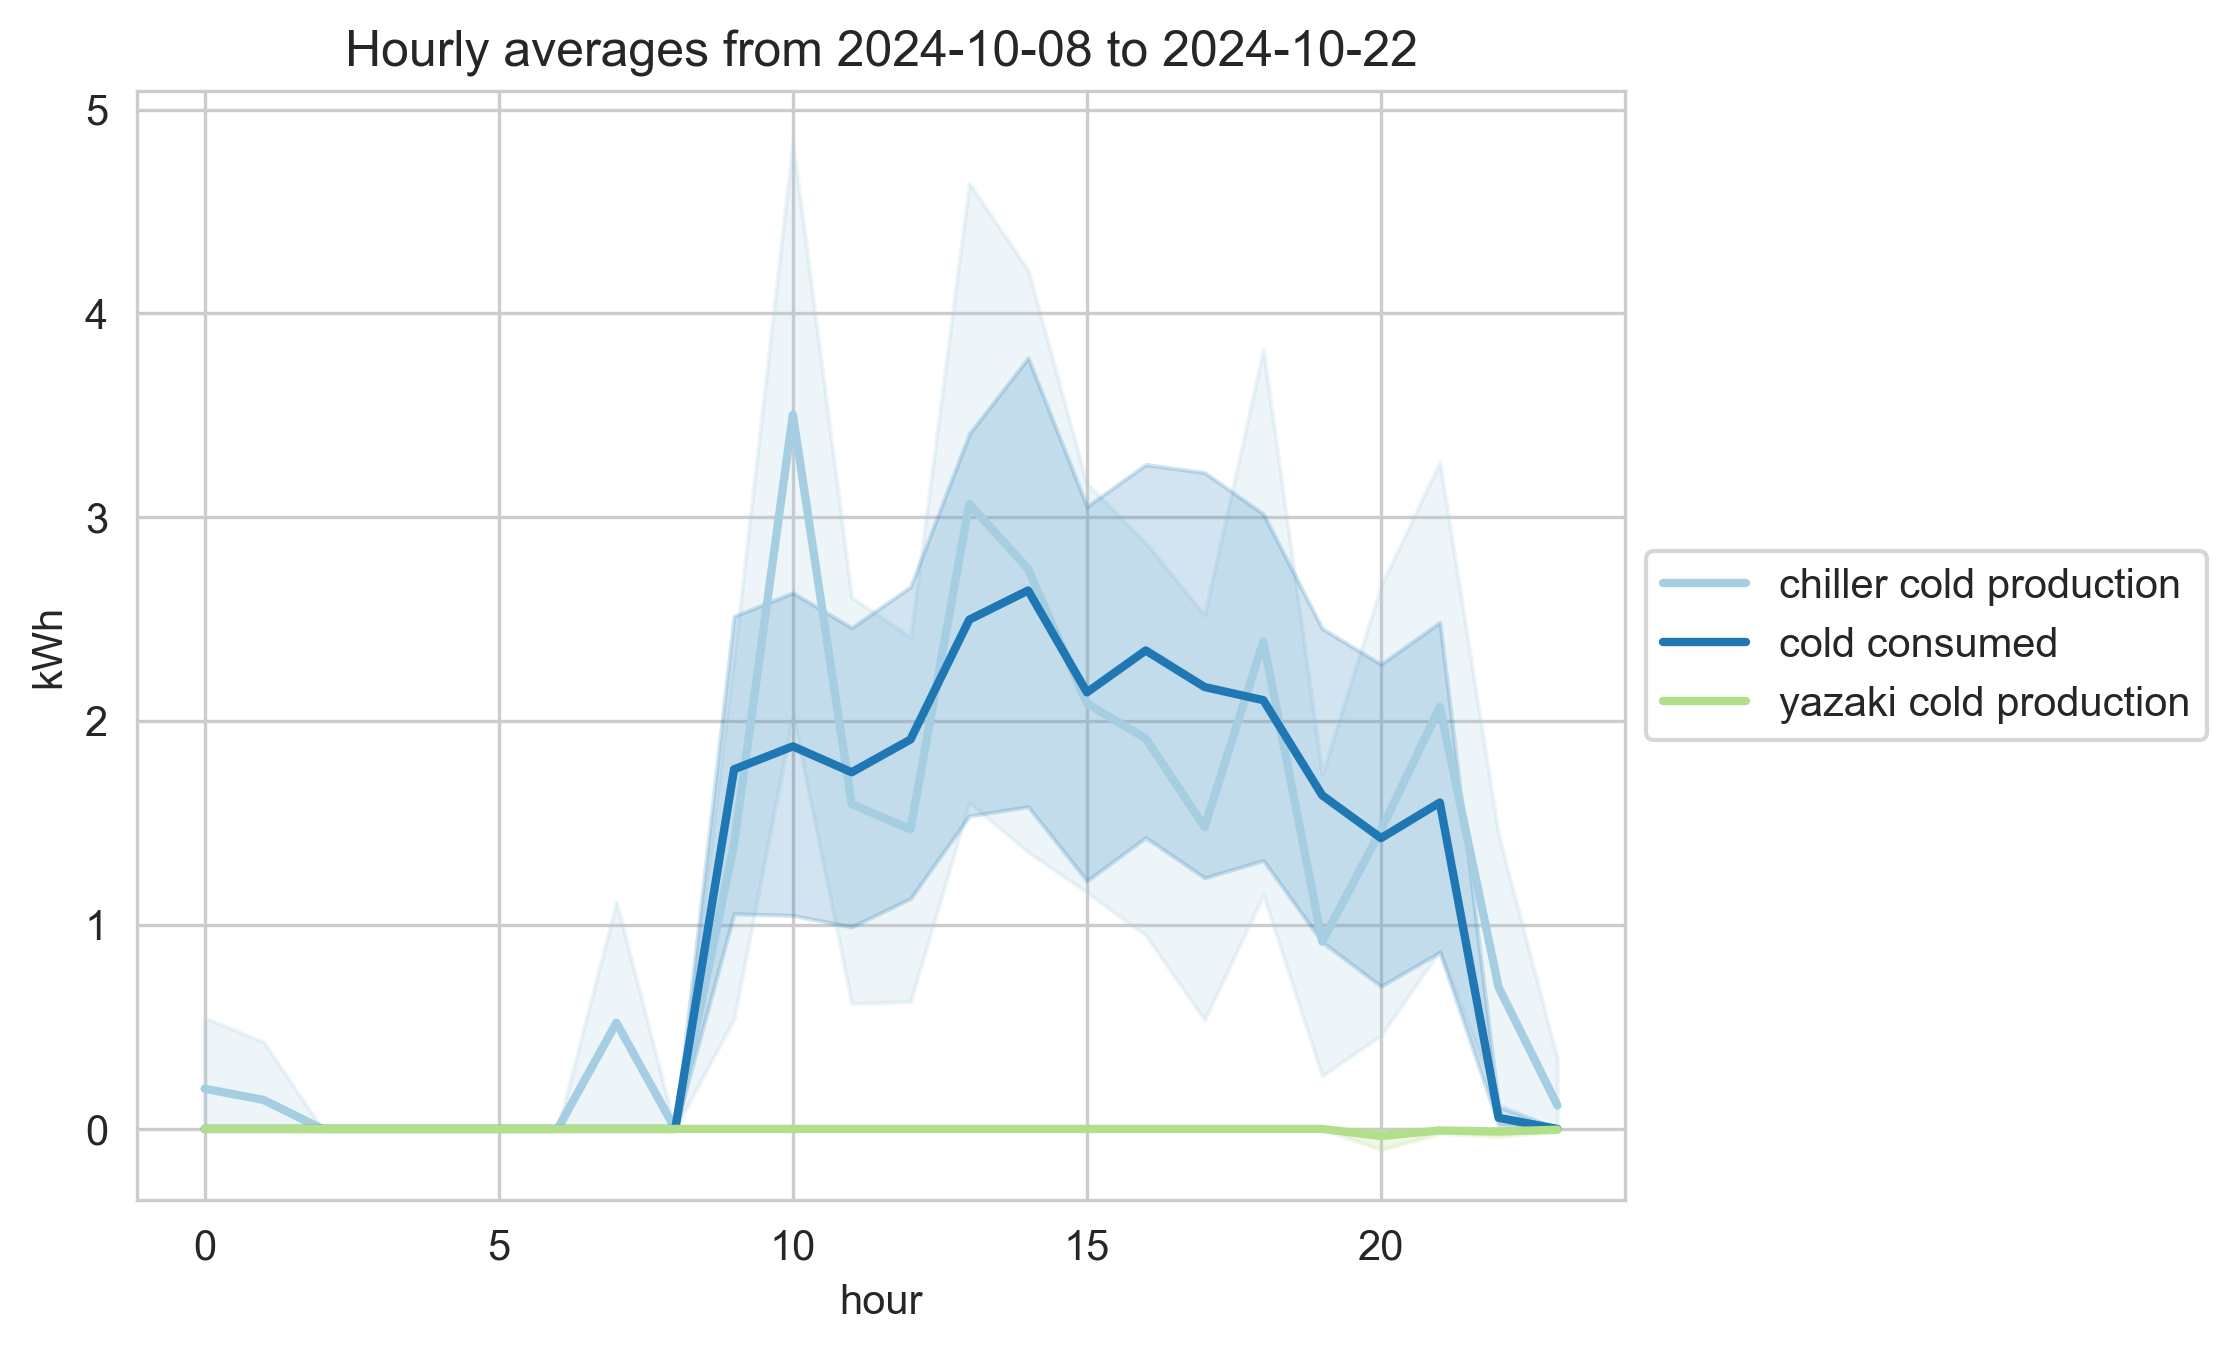

In [53]:
plot_daily_bars(kwh_thermal, 'kWh')
plot_hourly_avg(kwh_thermal, 'kWh')

## Water

### Aggregate water use and production

In [54]:
volume_variables = [
    "fresh_to_kitchen_flow_sensor_total_volume",
    "technical_to_wash_off_flow_sensor_total_volume",
    "technical_to_sanitary_flow_sensor_total_volume"
]

flow_variables = ["water_maker_production_flow"]

volumes_data = await get_data([{"_field": variable} for variable in volume_variables], (start, stop), timedelta(hours = 1), fl.WindowOperation.LAST, API_TOKEN)
volumes_data.index = volumes_data.index.tz_convert('Europe/Madrid')

flows_data = await get_data([{"_field": variable} for variable in flow_variables], (start, stop), timedelta(minutes = 1), fl.WindowOperation.MEAN, API_TOKEN)
flows_data.index = flows_data.index.tz_convert('Europe/Madrid')

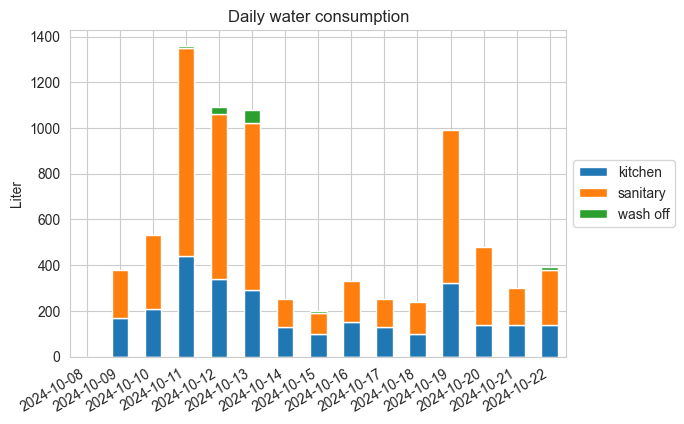

In [55]:
daily_consumed = (volumes_data.resample('d').last()*1000).diff().rename(columns = {"fresh_to_kitchen_flow_sensor_total_volume":"kitchen",
    "technical_to_wash_off_flow_sensor_total_volume":"wash off",
    "technical_to_sanitary_flow_sensor_total_volume":"sanitary"})
daily_consumed.index = daily_consumed.index.date
ax = daily_consumed.plot(kind = "bar", stacked = True)
plt.gcf().autofmt_xdate()
ax.set_ylabel("Liter")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Daily water consumption");

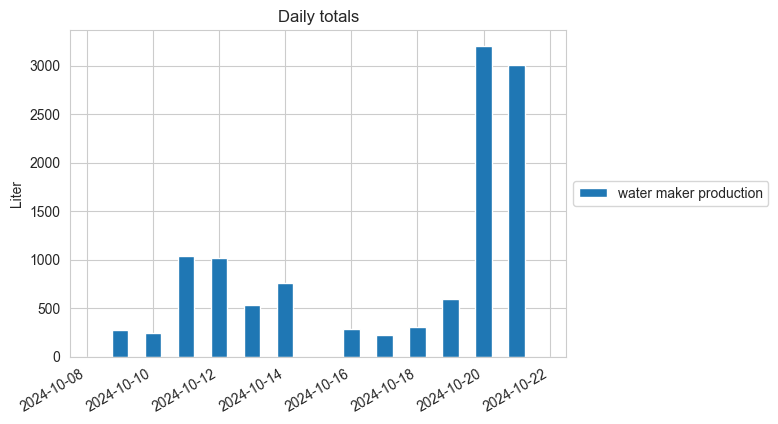

In [56]:
daily_water_maker = (flows_data["water_maker_production_flow"]).fillna(0).cumsum().resample('d').last().diff().to_frame('water maker production') #water maker flow is in liter/minute

plot_daily_bars(daily_water_maker, 'Liter')

### Water tank levels

In [57]:
storage_variables = [
    "fresh_water_tank_fill_ratio",
    "technical_water_tank_fill_ratio",
    "black_water_tank_fill_ratio"
]


storage_data = await get_data([{"_field": variable} for variable in storage_variables], (start, stop), timedelta(minutes = 1), fl.WindowOperation.MEAN, API_TOKEN)
storage_data.index = storage_data.index.tz_convert('Europe/Madrid')
storage_data = storage_data.rename(columns={"fresh_water_tank_fill_ratio":"fresh",
    "technical_water_tank_fill_ratio":"technical",
    "black_water_tank_fill_ratio":"black"})

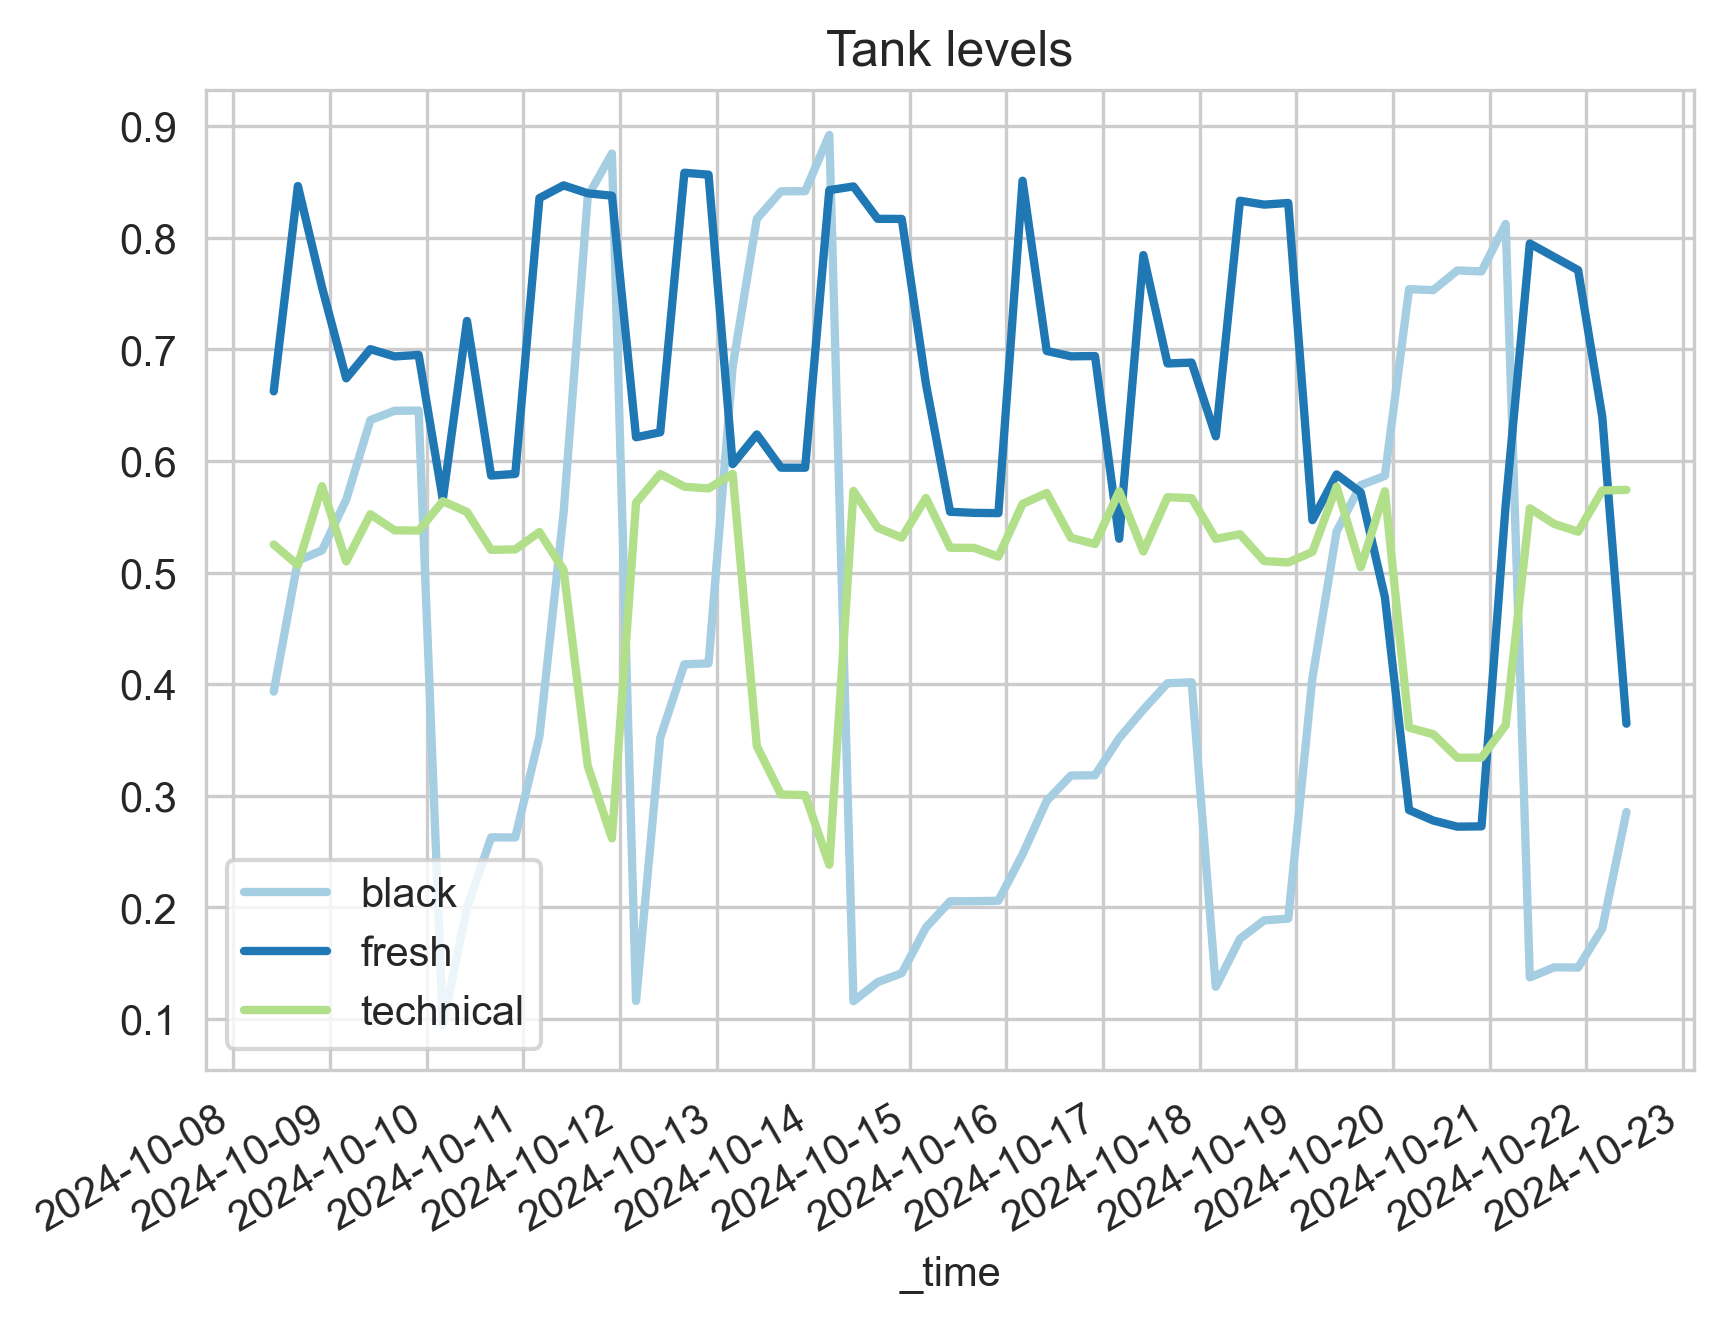

In [58]:
fig, ax = plt.subplots(dpi=300)
ax = sns.lineplot(data = storage_data.resample('6h').last(), palette = 'Paired', dashes = False, linewidth = 2.0, ax = ax)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
plt.gcf().autofmt_xdate()
plt.title('Tank levels');